In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gpytorch
import torch
import random

torch.set_default_device('cuda')

A) Unbounded nature of GP kernel leads to high variance on input boundary

In [22]:
ndim = 2
npts = 256
lengthscale = 0.5
kernel = gpytorch.kernels.MaternKernel()
kernel.lengthscale = lengthscale
spacing = 21

grids = torch.meshgrid([torch.linspace(0,1,spacing, device='cuda') for _ in range(ndim)], indexing='ij')
pts = torch.stack(tuple(grid.flatten() for grid in grids), dim=-1)
soboleng = torch.quasirandom.SobolEngine(dimension=ndim, scramble=True, seed=random.choice(range(0,10000000)))
in_pts0 = soboleng.draw(int(npts)).cuda()
example_variance = kernel(pts, pts) - kernel(pts, in_pts0) @ (kernel(in_pts0, in_pts0) + torch.eye(in_pts0.shape[0], device='cuda')).root_inv_decomposition() @ kernel(in_pts0, pts)
example_variance = torch.diag(example_variance.to_dense()).reshape([spacing] * ndim).detach().cpu().numpy()
in_pts0 = in_pts0.detach().cpu().numpy()

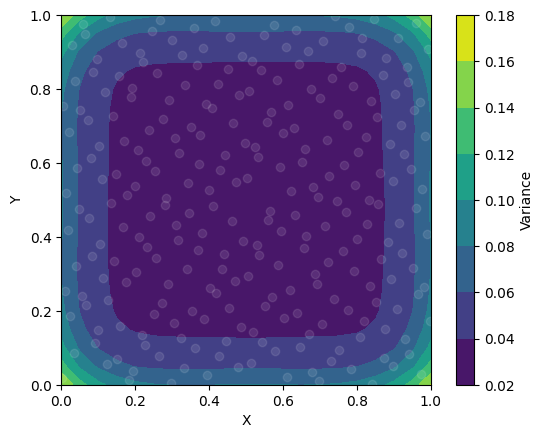

In [23]:
fig, ax = plt.subplots()
CS = plt.contourf(np.linspace(0,1,spacing), np.linspace(0,1,spacing), example_variance)
plt.scatter(in_pts0[:, 0], in_pts0[:, 1], c='white', alpha=0.1)
cbar = plt.gcf().colorbar(CS, ax=ax)
plt.xlabel('X')
plt.ylabel('Y')
cbar.set_label('Variance')
ax.set_aspect('equal', 'box')

B) Boundary variance increases with sample count for standard GP kernels

In [16]:
ndim = 2
npts_kernel = 2 ** np.arange(3, 11)
lengthscales = 0.5
n_draw = 10
kernels_volume_ratio = np.zeros((3, n_draw, len(npts_kernel)))
spacing = 21
grids = torch.meshgrid([torch.linspace(0,1,spacing, device='cuda'), torch.linspace(0,1,spacing, device='cuda')], indexing='ij')
pts = torch.stack((grids[0].flatten(), grids[1].flatten()), dim=1)

for l in range(3):
    if l == 0:
        kernel = gpytorch.kernels.MaternKernel().cuda()
    elif l == 1:
        kernel = gpytorch.kernels.RBFKernel().cuda()
    else:
        kernel = gpytorch.kernels.RQKernel().cuda()
    kernel.lengthscale = lengthscales
    
    for i in range(len(npts_kernel)):
        for j in range(n_draw):
            soboleng = torch.quasirandom.SobolEngine(dimension=2, scramble=True, seed=random.choice(range(0,10000000)))
            in_pts = soboleng.draw(int(npts_kernel[i])).cuda()
            variance = kernel(pts, pts) - kernel(pts, in_pts) @ (kernel(in_pts, in_pts) + torch.eye(in_pts.shape[0], device='cuda')).root_inv_decomposition() @ kernel(in_pts, pts)
            variance = torch.diag(variance.to_dense()).reshape(spacing, spacing)
            edge = torch.concatenate((variance[:-1, 0], variance[-1, :-1], variance[1:, -1], variance[0, 1:]))
            kernels_volume_ratio[l, j, i] = torch.sum(edge) / torch.sum(variance)
        print(f'{l}_{i}')

0_0
0_1
0_2
0_3
0_4
0_5
0_6
0_7
1_0
1_1
1_2
1_3
1_4
1_5
1_6
1_7
2_0
2_1
2_2
2_3
2_4
2_5
2_6
2_7


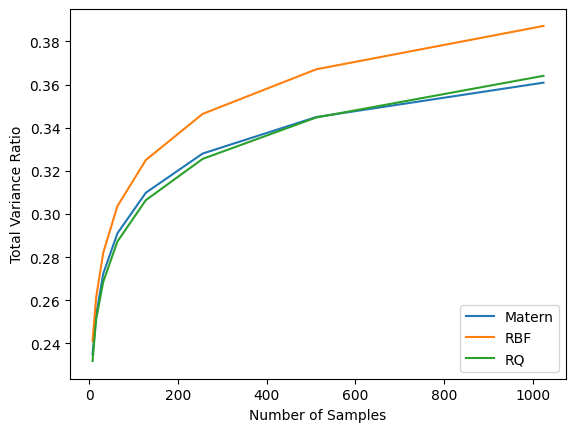

In [17]:
fig = plt.figure()
kernels = ['Matern', 'RBF', 'RQ']
for i in range(3):
    plt.fill_between(npts_kernel, np.quantile(kernels_volume_ratio[i,:,:], 0.25, axis=0), np.quantile(kernels_volume_ratio[i,:,:], 0.75, axis=0), alpha=0.3)
    plt.plot(npts_kernel, np.median(kernels_volume_ratio[i,:,:], axis=0), label=kernels[i])
plt.xlabel('Number of Samples')
plt.ylabel('Total Variance Ratio')
plt.legend(loc='lower right')

C-E) Combined effects of number of samples, length scale, and dimensionality on boundary variance

In [3]:
ndim = np.arange(1, 4)
npts_full = 2 ** np.arange(3, 11)
lengthscales_full = np.linspace(0.1, 0.9, 20)
n_draw = 10
full_variance_ratio = np.zeros((n_draw, len(ndim), len(npts_full), len(lengthscales_full)))
full_volume_ratio = np.zeros((n_draw, len(ndim), len(npts_full), len(lengthscales_full)))
kernel = gpytorch.kernels.MaternKernel().cuda()
spacing = 21

for n in range(len(ndim)):
    grids = torch.meshgrid([torch.linspace(0,1,spacing, device='cuda') for _ in range(ndim[n])], indexing='ij')
    pts = torch.stack(tuple(grid.flatten() for grid in grids), dim=-1)
    edge = torch.zeros(21, device='cuda', dtype=torch.bool)
    edge[0] = 1
    edge[-1] = 1
    boundary = torch.meshgrid([torch.clone(edge) for _ in range(ndim[n])], indexing='ij')
    boundary = torch.any(torch.stack(tuple(grid.flatten() for grid in boundary), dim=-1), dim=-1).reshape([spacing] * ndim[n])
    
    for l in range(len(lengthscales_full)):
        kernel.lengthscale = lengthscales_full[l]
        for i in range(len(npts_full)):
            for j in range(n_draw):
                soboleng = torch.quasirandom.SobolEngine(dimension=ndim[n], scramble=True, seed=random.choice(range(0,10000000)))
                in_pts = soboleng.draw(int(npts_full[i])).cuda()
                variance = kernel(pts, pts) - kernel(pts, in_pts) @ (kernel(in_pts, in_pts) + torch.eye(in_pts.shape[0], device='cuda')).root_inv_decomposition() @ kernel(in_pts, pts)
                variance = torch.diag(variance.to_dense()).reshape([spacing] * ndim[n])
                border = variance[boundary]
                full_variance_ratio[j, n, i, l] = torch.mean(border) / torch.mean(variance)
                full_volume_ratio[j, n, i, l] = torch.sum(border) / torch.sum(variance)
            print(f'{n}_{l}_{i}')

0_0_0
0_0_1
0_0_2
0_0_3
0_0_4
0_0_5
0_0_6
0_0_7
0_1_0
0_1_1
0_1_2
0_1_3
0_1_4
0_1_5
0_1_6
0_1_7
0_2_0
0_2_1
0_2_2
0_2_3
0_2_4
0_2_5
0_2_6
0_2_7
0_3_0
0_3_1
0_3_2
0_3_3
0_3_4
0_3_5
0_3_6
0_3_7
0_4_0
0_4_1
0_4_2
0_4_3
0_4_4
0_4_5
0_4_6
0_4_7
0_5_0
0_5_1
0_5_2
0_5_3
0_5_4
0_5_5
0_5_6
0_5_7
0_6_0
0_6_1
0_6_2
0_6_3
0_6_4
0_6_5
0_6_6
0_6_7
0_7_0
0_7_1
0_7_2
0_7_3
0_7_4
0_7_5
0_7_6
0_7_7
0_8_0
0_8_1
0_8_2
0_8_3
0_8_4
0_8_5
0_8_6
0_8_7
0_9_0
0_9_1
0_9_2
0_9_3
0_9_4
0_9_5
0_9_6
0_9_7
0_10_0
0_10_1
0_10_2
0_10_3
0_10_4
0_10_5
0_10_6
0_10_7
0_11_0
0_11_1
0_11_2
0_11_3
0_11_4
0_11_5
0_11_6
0_11_7
0_12_0
0_12_1
0_12_2
0_12_3
0_12_4
0_12_5
0_12_6
0_12_7
0_13_0
0_13_1
0_13_2
0_13_3
0_13_4
0_13_5
0_13_6
0_13_7
0_14_0
0_14_1
0_14_2
0_14_3
0_14_4
0_14_5
0_14_6
0_14_7
0_15_0
0_15_1
0_15_2
0_15_3
0_15_4
0_15_5
0_15_6
0_15_7
0_16_0
0_16_1
0_16_2
0_16_3
0_16_4
0_16_5
0_16_6
0_16_7
0_17_0
0_17_1
0_17_2
0_17_3
0_17_4
0_17_5
0_17_6
0_17_7
0_18_0
0_18_1
0_18_2
0_18_3
0_18_4
0_18_5
0_18_6
0_18_7
0_19_0
0_19_1
0_

Text(0, 0.5, 'Variance Volume Ratio')

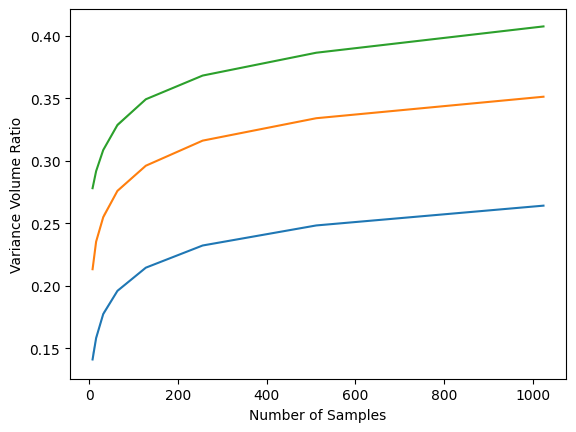

In [15]:
fig = plt.figure()
for i in range(3):
    plt.fill_between(npts_full, np.quantile(full_volume_ratio[:, i, :, 4], 0.25, axis=0),
                     np.quantile(full_volume_ratio[:, i, :, 4], 0.75, axis=0), alpha=0.3)
    plt.plot(npts_full, np.median(full_volume_ratio[:, i, :, 4], axis=0))
plt.xlabel('Number of Samples')
plt.ylabel('Variance Volume Ratio')

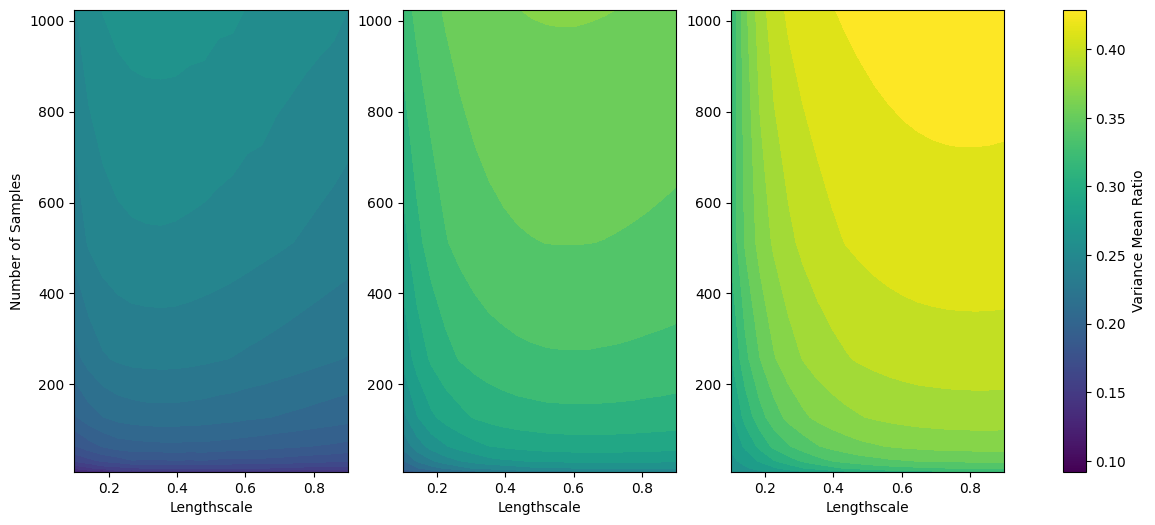

In [7]:
from matplotlib.colors import Normalize
import matplotlib
import matplotlib.cm as cm

fig = plt.figure(figsize=(15, 6))
axes = []
cmap = matplotlib.colormaps.get_cmap('viridis')
normalizer = Normalize(np.min(full_volume_ratio), np.max(full_volume_ratio))
im = cm.ScalarMappable(norm=normalizer)
axes.append(fig.add_subplot(131))
CS = plt.contourf(lengthscales_full, npts_full, np.mean(full_volume_ratio[:,0,:,:], axis=0), levels=15, cmap=cmap, norm=normalizer)
plt.xlabel('Lengthscale')
plt.ylabel('Number of Samples')
axes.append(fig.add_subplot(132))
CS2 = plt.contourf(lengthscales_full, npts_full, np.mean(full_volume_ratio[:,1,:,:], axis=0), levels=15, cmap=cmap, norm=normalizer)
plt.xlabel('Lengthscale')
axes.append(fig.add_subplot(133))
CS3 = plt.contourf(lengthscales_full, npts_full, np.mean(full_volume_ratio[:,2,:,:], axis=0), levels=15, cmap=cmap, norm=normalizer)
plt.xlabel('Lengthscale')
cbar = plt.gcf().colorbar(im, ax=axes)
cbar.set_label('Variance Mean Ratio')

G-I) Additional samples required to reverse boundary variance

In [18]:
ndim = np.arange(1, 4)
npts_corr = 2 ** np.arange(3, 10)
lengthscales = np.linspace(0.1, 0.9, 10)
n_draw = 10
kernel = gpytorch.kernels.MaternKernel().cuda()
spacing = 21
corrective_pts = np.zeros((len(ndim), len(npts_corr), len(lengthscales)))

for n in range(len(ndim)):
    grids = torch.meshgrid([torch.linspace(0,1,spacing, device='cuda') for _ in range(ndim[n])], indexing='ij')
    pts = torch.stack(tuple(grid.flatten() for grid in grids), dim=-1)
    edge = torch.zeros(21, device='cuda', dtype=torch.bool)
    edge[0] = 1
    edge[-1] = 1
    boundary = torch.meshgrid([torch.clone(edge) for _ in range(ndim[n])], indexing='ij')
    boundary = torch.any(torch.stack(tuple(grid.flatten() for grid in boundary), dim=-1), dim=-1).reshape([spacing] * ndim[n])
    inds = torch.nonzero(boundary)
    
    for l in range(len(lengthscales)):
        kernel.lengthscale = lengthscales[l]
        for i in range(len(npts_corr)):
            soboleng = torch.quasirandom.SobolEngine(dimension=ndim[n], scramble=True, seed=random.choice(range(0,10000000)))
            in_pts = soboleng.draw(int(npts_corr[i])).cuda()
            in_pts2 = torch.clone(in_pts)
            variance = kernel(pts, pts) - kernel(pts, in_pts) @ (kernel(in_pts, in_pts) + torch.eye(in_pts.shape[0], device='cuda')).root_inv_decomposition() @ kernel(in_pts, pts)
            variance = torch.diag(variance.to_dense()).reshape([spacing] * ndim[n])
            variance2 = torch.clone(variance)
            border = variance[boundary]
            nadd = 0
            difference = 1
            while difference > 0:
                I = torch.argmax(variance2[boundary])
                in_pts2 = torch.cat((in_pts2, inds[I:I+1, :] / (spacing - 1)), dim=0)
                variance2 = kernel(pts, pts) - kernel(pts, in_pts2) @ (kernel(in_pts2, in_pts2) + torch.eye(in_pts2.shape[0], device='cuda')).root_inv_decomposition() @ kernel(in_pts2, pts)
                variance2 = torch.diag(variance2.to_dense()).reshape([spacing] * ndim[n])
                difference = torch.median(variance2[boundary]) - torch.median(variance2)
                nadd += 1
            corrective_pts[n, i, l] = nadd
            print(f'{n}_{l}_{i}')

0_0_0
0_0_1
0_0_2
0_0_3
0_0_4
0_0_5
0_0_6
0_1_0
0_1_1
0_1_2
0_1_3
0_1_4
0_1_5
0_1_6
0_2_0
0_2_1
0_2_2
0_2_3
0_2_4
0_2_5
0_2_6
0_3_0
0_3_1
0_3_2
0_3_3
0_3_4
0_3_5
0_3_6
0_4_0
0_4_1
0_4_2
0_4_3
0_4_4
0_4_5
0_4_6
0_5_0
0_5_1
0_5_2
0_5_3
0_5_4
0_5_5
0_5_6
0_6_0
0_6_1
0_6_2
0_6_3
0_6_4
0_6_5
0_6_6
0_7_0
0_7_1
0_7_2
0_7_3
0_7_4
0_7_5
0_7_6
0_8_0
0_8_1
0_8_2
0_8_3
0_8_4
0_8_5
0_8_6
0_9_0
0_9_1
0_9_2
0_9_3
0_9_4
0_9_5
0_9_6
1_0_0
1_0_1
1_0_2
1_0_3
1_0_4
1_0_5
1_0_6
1_1_0
1_1_1
1_1_2
1_1_3
1_1_4
1_1_5
1_1_6
1_2_0
1_2_1
1_2_2
1_2_3
1_2_4
1_2_5
1_2_6
1_3_0
1_3_1
1_3_2
1_3_3
1_3_4
1_3_5
1_3_6
1_4_0
1_4_1
1_4_2
1_4_3
1_4_4
1_4_5
1_4_6
1_5_0
1_5_1
1_5_2
1_5_3
1_5_4
1_5_5
1_5_6
1_6_0
1_6_1
1_6_2
1_6_3
1_6_4
1_6_5
1_6_6
1_7_0
1_7_1
1_7_2
1_7_3
1_7_4
1_7_5
1_7_6
1_8_0
1_8_1
1_8_2
1_8_3
1_8_4
1_8_5
1_8_6
1_9_0
1_9_1
1_9_2
1_9_3
1_9_4
1_9_5
1_9_6
2_0_0
2_0_1
2_0_2
2_0_3
2_0_4
2_0_5
2_0_6
2_1_0
2_1_1
2_1_2
2_1_3
2_1_4
2_1_5
2_1_6
2_2_0
2_2_1
2_2_2
2_2_3
2_2_4
2_2_5
2_2_6
2_3_0
2_3_1
2_3_2
2_3_3
2_3_4
2_3_

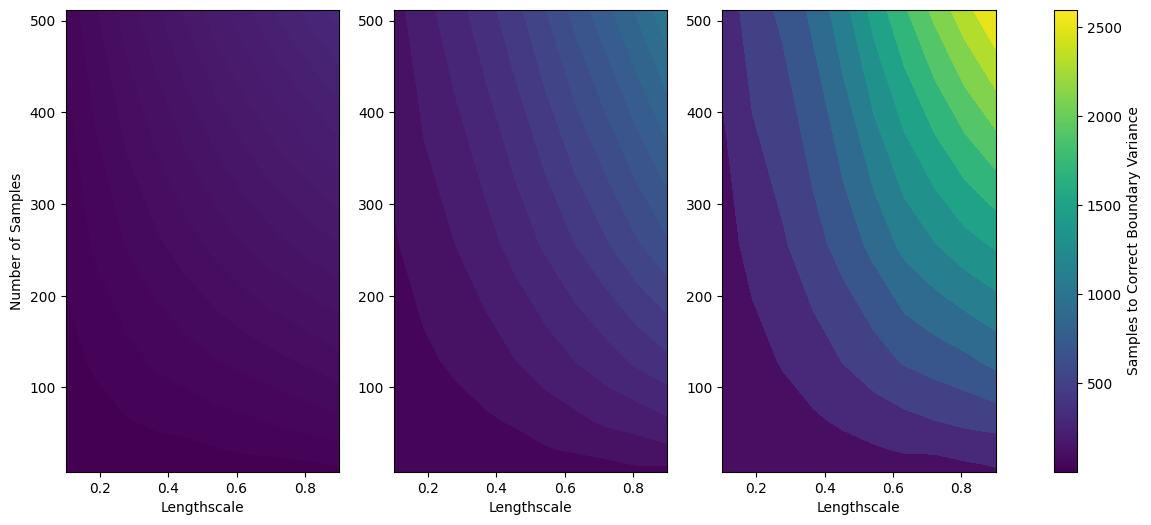

In [20]:
fig = plt.figure(figsize=(15, 6))
axes = []
cmap = matplotlib.colormaps.get_cmap('viridis')
normalizer = Normalize(np.min(corrective_pts), np.max(corrective_pts))
im = cm.ScalarMappable(norm=normalizer)
axes.append(fig.add_subplot(131))
CS = plt.contourf(lengthscales, npts_corr, corrective_pts[0,:,:], levels=15, cmap=cmap, norm=normalizer)
plt.xlabel('Lengthscale')
plt.ylabel('Number of Samples')
axes.append(fig.add_subplot(132))
CS2 = plt.contourf(lengthscales, npts_corr, corrective_pts[1,:,:], levels=15, cmap=cmap, norm=normalizer)
plt.xlabel('Lengthscale')
axes.append(fig.add_subplot(133))
CS3 = plt.contourf(lengthscales, npts_corr, corrective_pts[2,:,:], levels=15, cmap=cmap, norm=normalizer)
plt.xlabel('Lengthscale')
cbar = plt.gcf().colorbar(im, ax=axes)
cbar.set_label('Samples to Correct Boundary Variance')

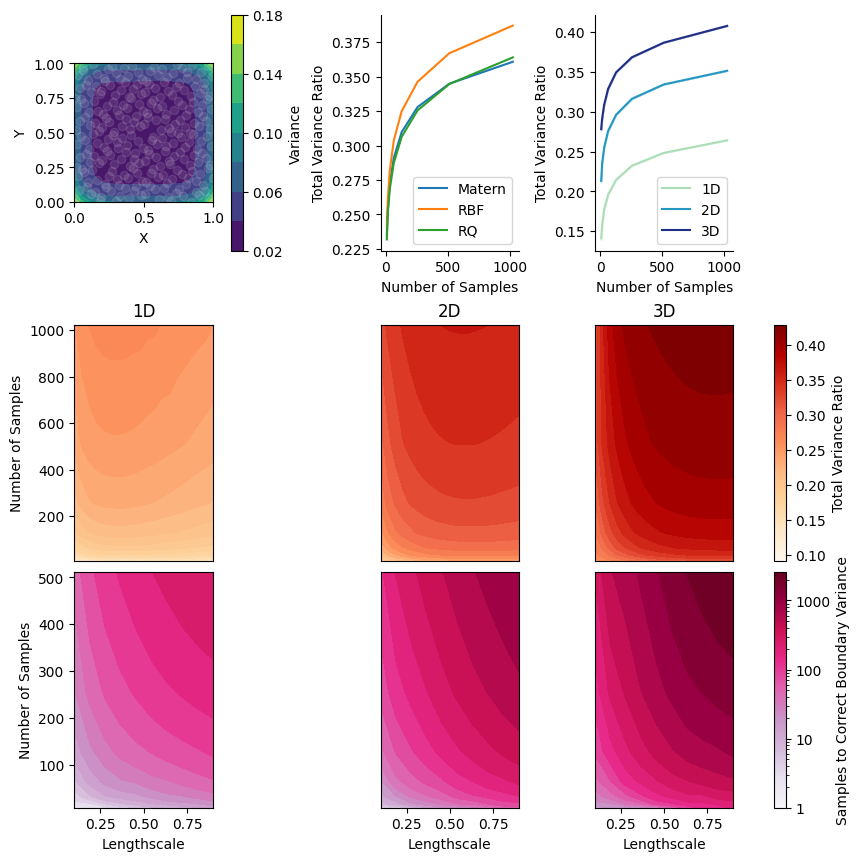

In [25]:
from matplotlib.ticker import LogFormatter
from matplotlib.colors import LogNorm

plt.rcParams['svg.fonttype'] = 'none'
full_fig = plt.figure(figsize=(8.5, 8.5), layout='constrained')
ax1 = plt.subplot(3,3,1)
CS0 = plt.contourf(np.linspace(0,1,spacing), np.linspace(0,1,spacing), example_variance)
plt.scatter(in_pts0[:, 0], in_pts0[:, 1], c='white', alpha=0.1)
cbar0 = plt.gcf().colorbar(CS0, ax=ax1, ticks=[0.02, 0.06, 0.1, 0.14, 0.18])
plt.xlabel('X')
plt.ylabel('Y')
ax1.set_aspect('equal')
cbar0.set_label('Variance')

ax2 = plt.subplot(3,3,2)
kernels = ['Matern', 'RBF', 'RQ']
for i in range(3):
    plt.fill_between(npts_kernel, np.quantile(kernels_volume_ratio[i,:,:], 0.25, axis=0), np.quantile(kernels_volume_ratio[i,:,:], 0.75, axis=0), alpha=0.3)
    plt.plot(npts_kernel, np.median(kernels_volume_ratio[i,:,:], axis=0), label=kernels[i])
plt.xlabel('Number of Samples')
plt.ylabel('Total Variance Ratio')
plt.legend(loc='lower right')
ax2.spines[['right', 'top']].set_visible(False)

ax3 = plt.subplot(3,3,3)
colororder = matplotlib.colormaps.get_cmap('YlGnBu')
for i in range(3):
    plt.fill_between(npts_full, np.quantile(full_volume_ratio[:, i, :, 4], 0.25, axis=0),
                     np.quantile(full_volume_ratio[:, i, :, 4], 0.75, axis=0), alpha=0.3, color=colororder((i+1)*0.3))
    plt.plot(npts_full, np.median(full_volume_ratio[:, i, :, 4], axis=0), label=f'{i+1}D', color=colororder((i+1)*0.3))
plt.xlabel('Number of Samples')
plt.ylabel('Total Variance Ratio')
plt.legend(loc='lower right')
ax3.spines[['right', 'top']].set_visible(False)

axes = []
cmap = matplotlib.colormaps.get_cmap('OrRd')
normalizer = Normalize(np.min(full_volume_ratio), np.max(full_volume_ratio))
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)
axes.append(plt.subplot(3,3,4))
plt.contourf(lengthscales_full, npts_full, np.mean(full_volume_ratio[:,0,:,:], axis=0), levels=15, cmap=cmap, norm=normalizer)
plt.xticks([])
plt.ylabel('Number of Samples')
plt.title('1D')
axes.append(plt.subplot(3,3,5, sharex=axes[0]))
plt.contourf(lengthscales_full, npts_full, np.mean(full_volume_ratio[:,1,:,:], axis=0), levels=15, cmap=cmap, norm=normalizer)
plt.xticks([])
plt.yticks([])
plt.title('2D')
axes.append(plt.subplot(3,3,6, sharex=axes[0]))
plt.contourf(lengthscales_full, npts_full, np.mean(full_volume_ratio[:,2,:,:], axis=0), levels=15, cmap=cmap, norm=normalizer)
cbar = plt.gcf().colorbar(im, ax=axes)
cbar.set_label('Total Variance Ratio')
plt.xticks([])
plt.yticks([])
plt.title('3D')

axes2 = []
cmap2 = matplotlib.colormaps.get_cmap('PuRd')
normalizer = LogNorm(np.min(corrective_pts), np.max(corrective_pts))
im2 = cm.ScalarMappable(norm=normalizer, cmap=cmap2)
axes2.append(plt.subplot(3,3,7))
CS = plt.contourf(lengthscales, npts_corr, corrective_pts[0,:,:], levels=np.logspace(np.log10(corrective_pts[0,:,:].min()),np.log10(corrective_pts[0,:,:].max()), 15), cmap=cmap2, norm=normalizer)
plt.xlabel('Lengthscale')
plt.ylabel('Number of Samples')
axes2.append(plt.subplot(3,3,8))
CS2 = plt.contourf(lengthscales, npts_corr, corrective_pts[1,:,:], levels=np.logspace(np.log10(corrective_pts[1,:,:].min()),np.log10(corrective_pts[1,:,:].max()), 15), cmap=cmap2, norm=normalizer)
plt.xlabel('Lengthscale')
plt.yticks([])
axes2.append(plt.subplot(3,3,9))
CS3 = plt.contourf(lengthscales, npts_corr, corrective_pts[2,:,:], levels=np.logspace(np.log10(corrective_pts[2,:,:].min()),np.log10(corrective_pts[2,:,:].max()), 15), cmap=cmap2, norm=normalizer)
plt.xlabel('Lengthscale')
plt.yticks([])
formatter = LogFormatter(10, labelOnlyBase=False)
cbar2 = plt.gcf().colorbar(im2, ax=axes2, format=formatter)
cbar2.set_label('Samples to Correct Boundary Variance')
plt.savefig('figures/figure3.svg')